In [1]:
from scipy import stats
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json

In [2]:
files = glob.glob("dados/*.json")

- Número total de Tweets

In [3]:
size = 0
for each in files:
    with open(each, 'r', encoding="utf8") as f:
        data = json.load(f)
        size += len(data)

- Distribuição do tamanho das florestas. Cada Tweet gera uma floresta.
Gerar o gráfico da CDF dos tamanhos das florestas de cada Tweet;

In [3]:
size_forests = dict()
for filename in files:
    fa = filename.split("_")
    fa = fa[1].split(".")
    with open(filename, 'r', encoding="utf8") as f:
        try:
            size_forests[fa[0]] += len(json.load(f))
        except:
            size_forests[fa[0]] = len(json.load(f))
                

In [4]:
np_forests = np.array(tuple(size_forests.values()))

In [5]:
ecdf = ECDF(np_forests)

In [8]:
parameters = np.full(len(np_forests), 1000)

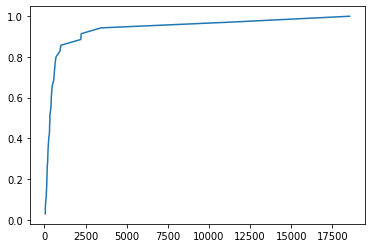

In [10]:
plt.plot(ecdf.x, ecdf.y)

In [ ]:
plt

- Para cada árvore principal (respostas e replies diretas ao Tweet),
gerar a distribuição do tamanho, altura e "largura" (pensar em formas
de descrever as árvores com números.)

- Para cada árvore secundária (arvores das citações) fazer o mesmo do
item acima.

- Para cada interação com um tweet, calcular o tempo entre a interação
e o pai imediatamente acima (resposta e tweet respondido). Fazer uma
distribuição desses valores de tempos de resposta.

In [17]:
for filename in files:
    with open(filename, 'r', encoding="utf8") as f:    
        data = json.load(f)
        for item in data:
            replie_to = data[item]['replie_to']
            if(replie_to is not None):
                data[item]['response_time'] = data[item]['created_at'] - data[replie_to]['created_at']
            else:
                data[item]['response_time'] = 0.0
    with open(filename, 'w', encoding="utf8") as f:
        f.write(json.dumps(data, ensure_ascii=False))

- Número de usuários diferentes em cada árvore (fazer para a árvore
principal e para as secundárias).

In [35]:
tree_users = dict()
for filename in files:
    fa = filename[14:len(filename) - 5]
    different_users = dict()
    with open(filename, 'r', encoding="utf8") as f:   
        data = json.load(f)
        for item in data:
            try:
                different_users[data[item]['user_id']] += 1
            except:
                different_users[data[item]['user_id']] = 1
            tree_users[fa] = len(different_users)